# Neural Net for Dog Image Recognition

## Environment Setup

Import libraries and mount Drive

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

In [0]:
%matplotlib inline
import os, cv2
import pandas as pd
import numpy as np
from sklearn import neural_network
import scipy.io as sio
import tarfile
from IPython.display import SVG

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,Dropout,Concatenate,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import model_to_dot, plot_model

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam,SGD

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

import matplotlib.pyplot as plt
import random as rn
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.507948369000019
GPU (s):
0.10152859300001182
GPU speedup over CPU: 34x


In [0]:
# for tpu optimization
'''
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
'''

"\ntry:\n  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection\n  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])\nexcept ValueError:\n  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')\n\ntf.config.experimental_connect_to_cluster(tpu)\ntf.tpu.experimental.initialize_tpu_system(tpu)\ntpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)\n"

In [0]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

## Import train and test data

In [0]:
# Define function to download .mat files
def loadMatFile(file_name):
  root_path = 'drive/My Drive/DogApp/'
  return sio.loadmat(root_path + file_name)

In [0]:
# Import train and test sets
train_dict = loadMatFile('train_data.mat')
test_dict = loadMatFile('test_data.mat')
train_data = train_dict['train_data']
test_data = test_dict['test_data']

In [8]:
def extract_labels(regex_pattern, dictionary, return_type):
    label_list = []
    if 'train' in '{}'.format(dictionary):
        prefix = 'train'
        for array in dictionary['{}_info'.format(prefix)][0][0][0]:
            label_list.append(re.search(regex_pattern, array[0][0]).group(1))
    elif 'test' in '{}'.format(dictionary):
        prefix = 'test'
        for array in dictionary['{}_info'.format(prefix)][0][0][0]:
            label_list.append(re.search(regex_pattern, array[0][0]).group(1))
    else:
        print('Error: please check your input dictionary. You may have entered the name of a non-existant dictionary.')
    print('Processed {} {} labels!'.format(len(label_list), prefix))
    if return_type == 'series':
        return pd.Series(label_list)
    elif return_type == 'array':
        return np.asarray(label_list)
    elif return_type == 'list':
        return label_list

train_labels = extract_labels(regex_pattern = '-(.*?)/n', dictionary = train_dict, return_type = 'series')
test_labels = extract_labels(regex_pattern = '-(.*?)/n', dictionary = test_dict, return_type = 'series')

Processed 12000 train labels!
Processed 8580 test labels!


In [9]:
test_labels_numeric, uniques = test_labels.factorize()
train_labels_numeric, uniques = train_labels.factorize()
test_labels_numeric

array([  0,   0,   0, ..., 119, 119, 119])

In [0]:
def label_assignment(img,label):
    return label

def training_data(label,data_dir):
    for img in tqdm(os.listdir(data_dir)):
        label = label_assignment(img,label)
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [0]:
root_path = 'drive/My Drive/DogApp/'

chihuahua_dir = root_path + '/data/Images/n02085620-Chihuahua'
japanese_spaniel_dir = root_path + '/data/Images/n02085782-Japanese_spaniel'
maltese_dir = root_path + '/data/Images/n02085936-Maltese_dog'
pekinese_dir = root_path + '/data/Images/n02086079-Pekinese'
shitzu_dir = root_path + '/data/Images/n02086240-Shih-Tzu'
blenheim_spaniel_dir = root_path + '/data/Images/n02086646-Blenheim_spaniel'
papillon_dir = root_path + '/data/Images/n02086910-papillon'
toy_terrier_dir = root_path + '/data/Images/n02087046-toy_terrier'
afghan_hound_dir = root_path + '/data/Images/n02088094-Afghan_hound'
basset_dir = root_path + '/data/Images/n02088238-basset'


X = []
Z = []
imgsize = 150

In [15]:
training_data('chihuahua',chihuahua_dir)
training_data('japanese_spaniel',japanese_spaniel_dir)
training_data('maltese',maltese_dir)
training_data('pekinese',pekinese_dir)
training_data('shitzu',shitzu_dir)
training_data('blenheim_spaniel',blenheim_spaniel_dir)
training_data('papillon',papillon_dir)
training_data('toy_terrier',toy_terrier_dir)
training_data('afghan_hound',afghan_hound_dir)
training_data('basset',basset_dir)

100%|██████████| 175/175 [00:49<00:00,  3.51it/s]


In [0]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)
Y = to_categorical(Y,10)
X = np.array(X)
X=X/255

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=24)

In [56]:
x_train.shape

(1345, 150, 150, 3)

In [0]:
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

augs_gen.fit(x_train)

In [0]:
generated = augs_gen.flow(x_train,y_train,batch_size=1000)

In [64]:
generated

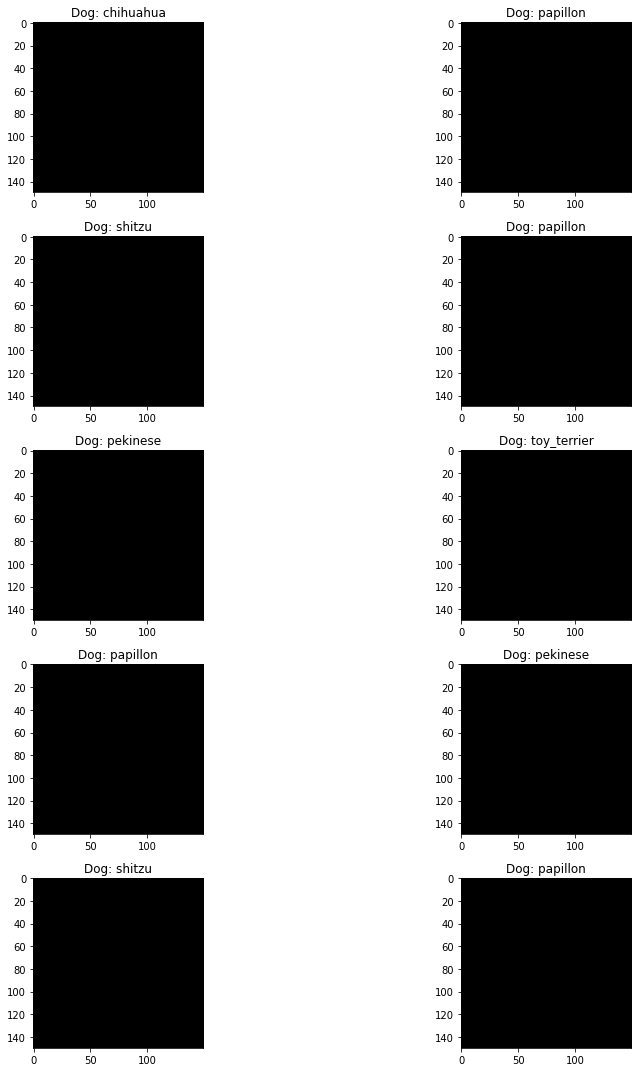

In [24]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Dog: '+Z[l])
        
plt.tight_layout()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4936323be0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f493635a1d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4936310978> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4936323588> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f49362c8550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f493630f710> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f493630f9b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f49362cde10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f49362cd630> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f49362d5e48> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f49362d8d68> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

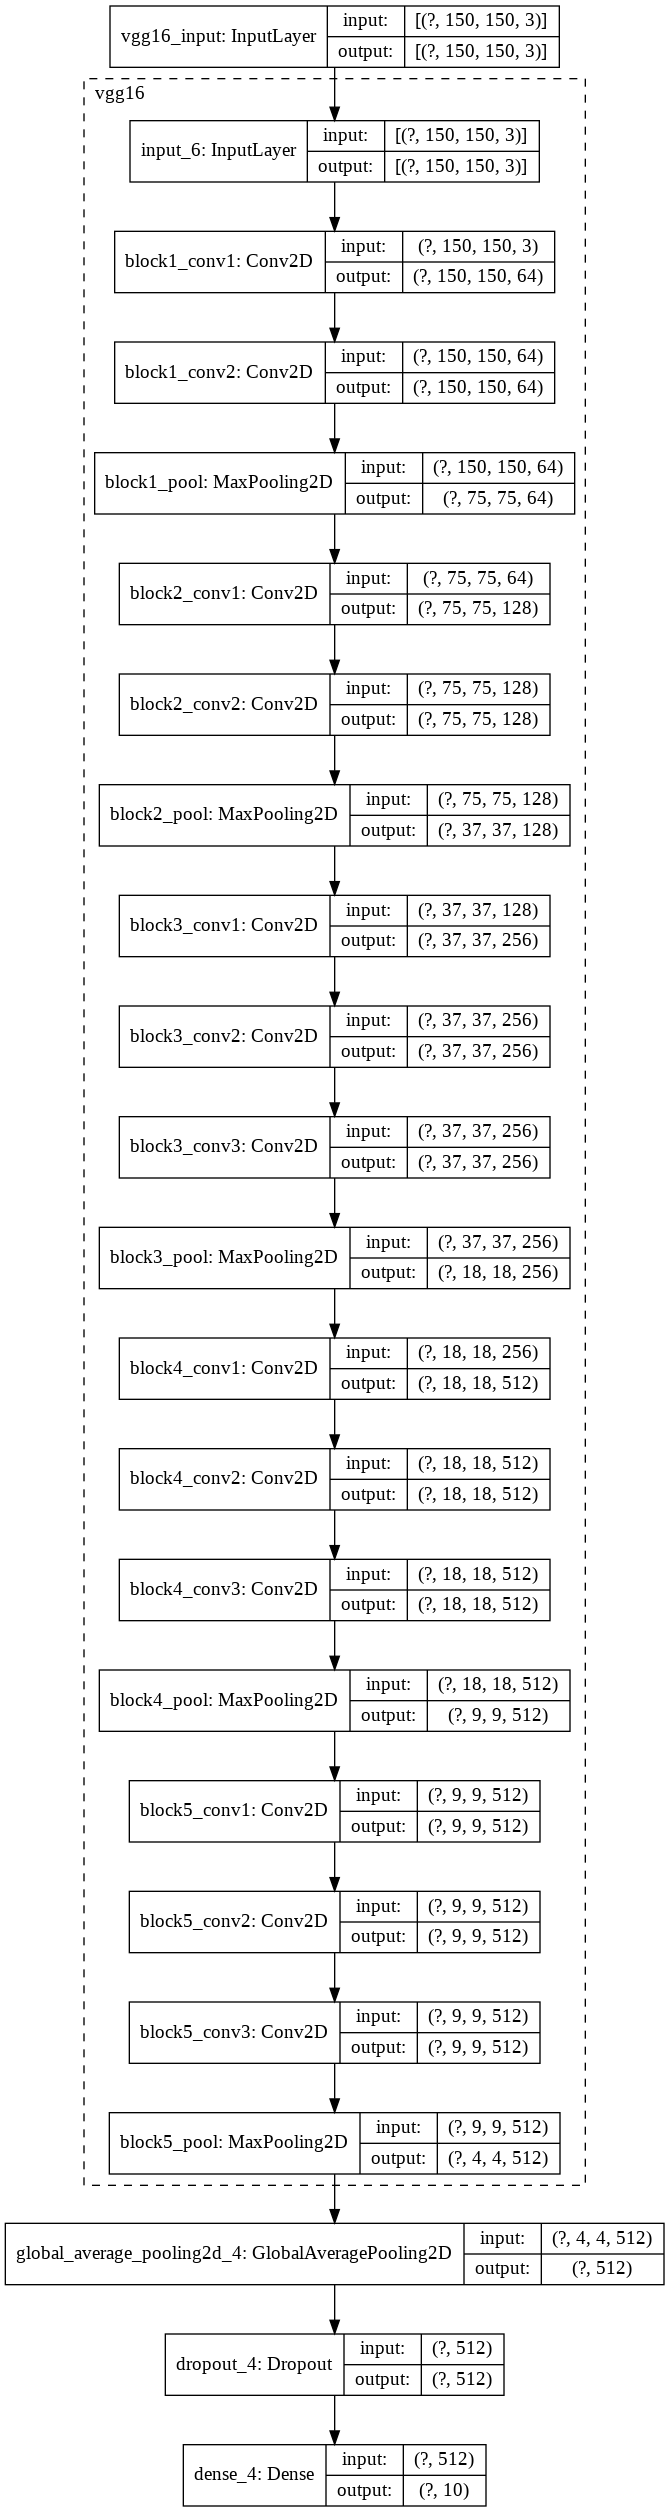

In [45]:
base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)


In [48]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [67]:
#-----------Optimizers-----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)
#----------Compile---------------#
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#-----------Training------------#
history = model.fit_generator(
    augs_gen.flow(x_train,y_train,batch_size=500),
    validation_data  = (x_test,y_test),
    validation_steps = 1000,
    steps_per_epoch  = 1000,
    epochs = 20,
    verbose = 1,
    callbacks=callbacks
)

  ...
    to  
  ['...']
Train for 1000 steps, validate on 577 samples
Epoch 1/20
   3/1000 [..............................] - ETA: 1:38:13 - loss: 2.3247 - accuracy: 0.1227WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20000 batches). You may need to use the repeat() function when building your dataset.


In [0]:
image_count = int(input('Enter the number of images you would like to train on: '))
#y_binary = to_categorical(train_labels)

#image_count = 200
model = Sequential()
model.add(Conv1D(120, kernel_size=3, activation='relu', input_shape=(12000,3)))
#model.add(Dense(2000, activation = 'relu', input_shape = (12000,)))
model.add(Flatten())
model.add(Dense(250, activation = 'relu'))
model.add(Dense(250, activation = 'relu'))
model.add(Dense(250, activation = 'relu'))
model.add(Dense(250, activation = 'relu'))
model.add(Dense(120, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_data[:image_count], train_labels_numeric[:image_count], validation_split = 0.2, epochs = 100)

Enter the number of images you would like to train on: 300


ResourceExhaustedError: ignored

In [0]:
# Define function to download .mat files
def loadMatFile(file_name):
  root_path = 'drive/My Drive/DogApp/'
  return sio.loadmat(root_path + file_name)

def loadTarFile(file_name, mode = 'r'):
  root_path = 'drive/My Drive/DogApp/'
  return tarfile.open(root_path + file_name, mode)

In [0]:
# Import train and test sets
train_dict = loadMatFile('train_data.mat')
test_dict = loadMatFile('test_data.mat')
train_data = train_dict['train_data']
test_data = test_dict['test_data']

In [0]:
lists = loadTarFile(file_name = 'lists.tar')

In [0]:
for member in lists.getmembers():
  member_name = member.getname()
  'tar_' + member_name = tarfile.extract(member)
  print(member)



<TarInfo 'file_list.mat' at 0x7fab9b080f20>
<TarInfo 'train_list.mat' at 0x7fab9b080d90>
<TarInfo 'test_list.mat' at 0x7fab9b080cc8>


## Exploratory Data Analysis

In [0]:
train_dict

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Mar 28 12:03:37 2012',
 '__version__': '1.0',
 'train_data': array([[1.        , 0.37021212, 0.38627623, ..., 0.21216631, 0.33752761,
         0.26825407],
        [0.37021212, 1.        , 0.45434285, ..., 0.14359524, 0.3095    ,
         0.17709522],
        [0.38627623, 0.45434285, 1.        , ..., 0.16968838, 0.28702648,
         0.20437348],
        ...,
        [0.21216631, 0.14359524, 0.16968838, ..., 1.        , 0.22314713,
         0.41941136],
        [0.33752761, 0.3095    , 0.28702648, ..., 0.22314713, 1.        ,
         0.31585238],
        [0.26825407, 0.17709522, 0.20437348, ..., 0.41941136, 0.31585238,
         1.        ]]),
 'train_fg_data': array([[4.32900433e-04, 2.88600289e-04, 2.88600289e-04, ...,
         3.96825397e-04, 3.24675325e-04, 2.30880231e-03],
        [0.00000000e+00, 6.34920635e-04, 6.98412698e-04, ...,
         1.90476190e-04, 3.17460317e-05, 4.09523810e-03],

In [0]:
train_data[100].shape

(12000,)

In [0]:
train_data.shape

(12000, 12000)

In [0]:
test_data.shape

(8580, 12000)

In [0]:
test_data[0]

array([0.42297642, 0.44567102, 0.44322268, ..., 0.11023967, 0.28878223,
       0.16612349])

In [0]:
resized_img = test_data[0].resize((227, 227))

ValueError: ignored

In [0]:
img = Image.fromarray(test_data[0].reshape(32,32,3), 'RGB') 

ValueError: ignored

IndexError: ignored

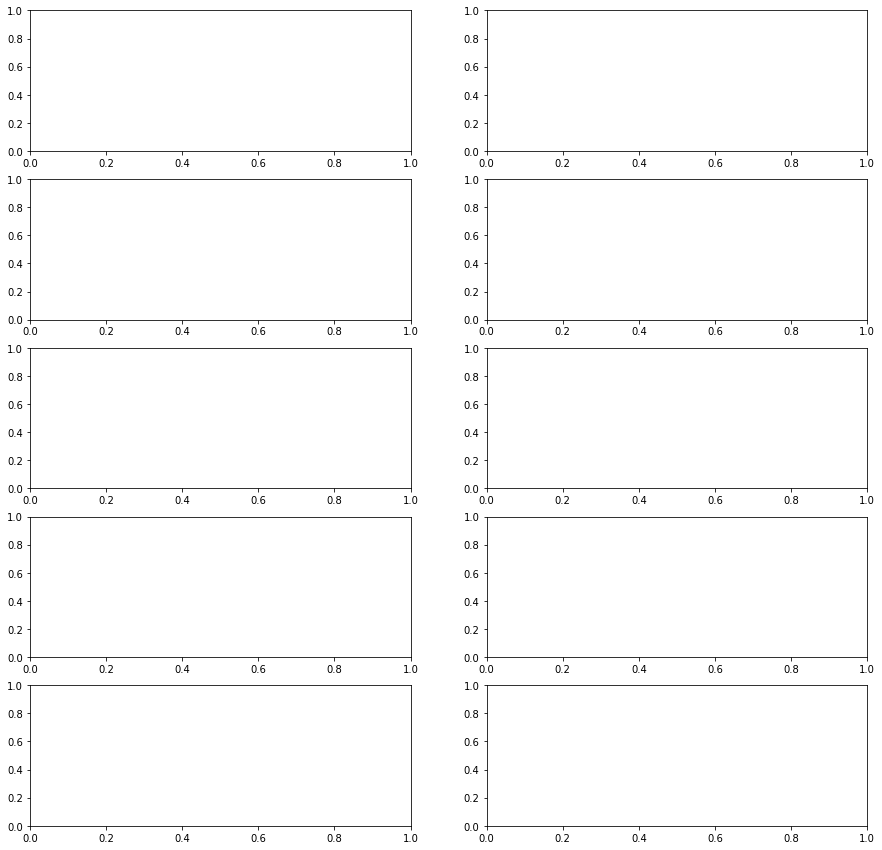

In [0]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Dog: '+Z[l])
        
plt.tight_layout()

## Model Instantiation

In [0]:
MLPC_nn = neural_network.MLPClassifier()